In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import PIL
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
import os

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = datasets.CIFAR10(root='../../datasets/CIFAR10', train=True, download=True, transform=transform)

Files already downloaded and verified


In [4]:
#data augmentation
trainset.train_data = np.concatenate((trainset.train_data, trainset.train_data[::-1, :]))
trainset.train_labels = np.concatenate((trainset.train_labels, trainset.train_labels[::-1]))

In [5]:
train_loader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

In [6]:
testset = datasets.CIFAR10(root='../../datasets/CIFAR10', train=False, download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


In [7]:
classes = np.array(('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            # 3 x 32 x 32
            nn.Conv2d(3, 10, 3, 1, 1),
            nn.LeakyReLU(0.2),
            
            # 10 x 32 x 32
            nn.Conv2d(10, 32, 3, 1, 1),
            nn.LeakyReLU(0.2),
            
            # 32 x 32 x 32
            nn.MaxPool2d(2, 2),
            
            # 32 x 16 x 16
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.LeakyReLU(0.2),
            
            # 64 x 16 x 16
            nn.MaxPool2d(2, 2),
            
            # 64 x 8 x 8
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.LeakyReLU(0.2)
            
            
            # output ==> 128 x 8 x 8
        )
        
        # 128 x 8 x 8
        self.avg_pool = nn.AvgPool2d(8)
        
        # 128 x 1 x 1
        self.fc = nn.Linear(128, 10)
        
    def forward(self, x):
        features = self.conv(x)
        flatten = self.avg_pool(features).view(features.size(0), -1)
        output = self.fc(flatten)
        
        return output, features
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
start = time.time()
print('\n ==> Training Start')

epochs = 30
for epoch in range(epochs):
    total_loss =  0.0
    
    for data, target in train_loader:
        train_x, train_y = data.float().to(device), target.long().to(device)
        optimizer.zero_grad()
        outputs, f = model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print('\n epoch %d' % (epoch+1), total_loss)
end = time.time()

print('Elapsed Time : %.3f' % (end-start))


 ==> Training Start

 epoch 1 518.7342427074909

 epoch 2 510.91579224169254

 epoch 3 485.23910000920296

 epoch 4 477.94163171947

 epoch 5 459.6923018395901

 epoch 6 454.1905832886696

 epoch 7 443.28676126897335

 epoch 8 437.9777626246214

 epoch 9 433.3748295903206

 epoch 10 407.0929265767336

 epoch 11 421.59972900152206

 epoch 12 392.1478985324502

 epoch 13 416.0734255462885

 epoch 14 377.46743243932724

 epoch 15 392.82674990594387

 epoch 16 376.55812836810946

 epoch 17 387.3875379562378

 epoch 18 379.403416313231

 epoch 19 357.9401377812028

 epoch 20 379.0621579363942

 epoch 21 365.1433058157563

 epoch 22 369.5362025126815

 epoch 23 365.01693718880415

 epoch 24 359.43296130001545

 epoch 25 363.03843618929386

 epoch 26 348.87729338184

 epoch 27 355.1811972334981

 epoch 28 358.56028544157743

 epoch 29 349.9597261697054

 epoch 30 359.6157085299492
Elapsed Time : 460.501


In [15]:
correct = 0
total = 0

for data, target in test_loader:
    test_x, test_y = Variable(data).cuda(), Variable(target).cuda()
    outputs, _ = model(test_x)
    _, predicted = torch.max(outputs, 1)
    
    total += test_y.size(0)
    correct += (predicted.cpu() == test_y.cpu()).sum().item()

print('Acc : %.3f' % ((correct/total) * 100))
    

Acc : 73.750


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    model.eval()
    for data, target in test_loader:
        images, labels = Variable(data).cuda(), Variable(target).cuda()
        outputs, _ = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels.cpu()).squeeze()
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i])) 

Accuracy of plane : 85 %
Accuracy of   car : 85 %
Accuracy of  bird : 68 %
Accuracy of   cat : 51 %
Accuracy of  deer : 78 %
Accuracy of   dog : 64 %
Accuracy of  frog : 74 %
Accuracy of horse : 70 %
Accuracy of  ship : 76 %
Accuracy of truck : 81 %


torch.Size([100, 3, 32, 32])


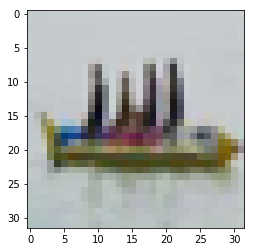

In [17]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2 ,0)))


dataiter = iter(test_loader)
images1, labels1 = dataiter.next()

imshow(torchvision.utils.make_grid(images[0].cpu()))
print(images.shape)

Predict : ship 	 Ans : ship


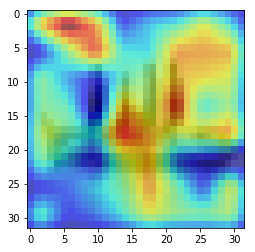

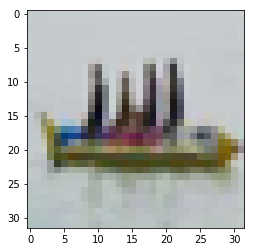

Predict : frog 	 Ans : cat


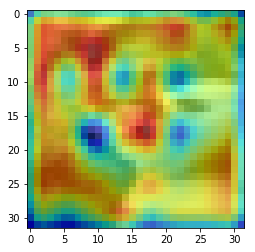

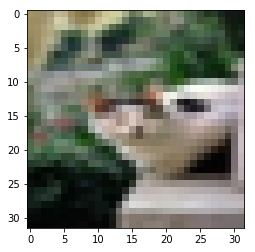

Predict : frog 	 Ans : frog


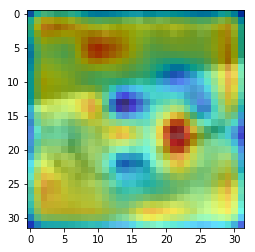

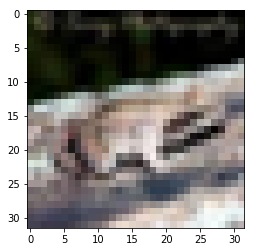

Predict : frog 	 Ans : frog


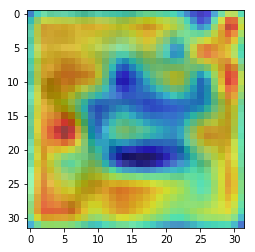

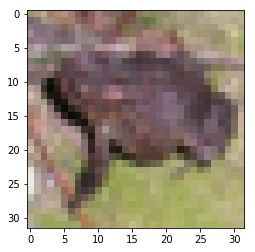

Predict : plane 	 Ans : plane


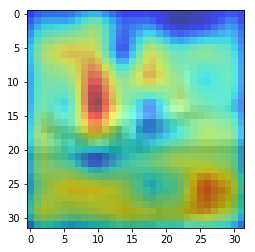

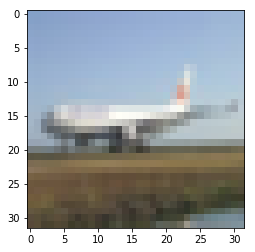

Predict : car 	 Ans : car


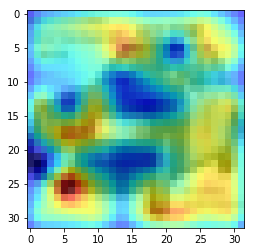

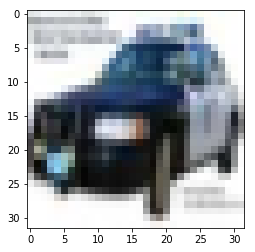

Predict : car 	 Ans : car


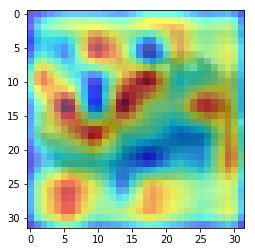

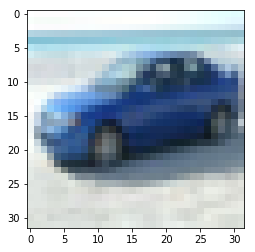

Predict : car 	 Ans : car


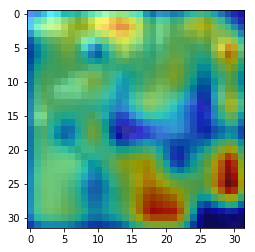

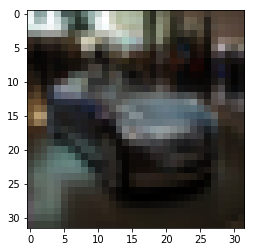

Predict : plane 	 Ans : ship


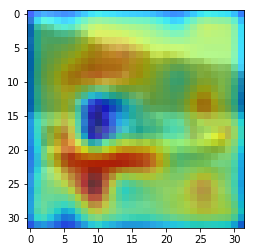

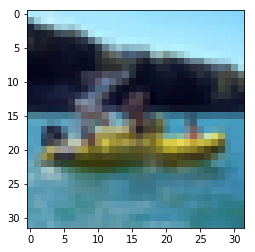

Predict : car 	 Ans : car


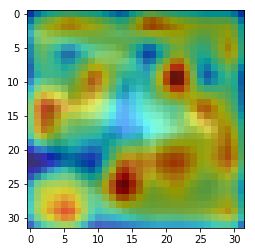

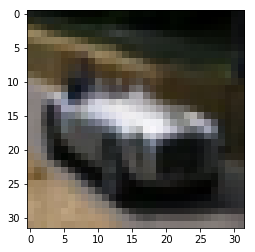

Predict : deer 	 Ans : deer


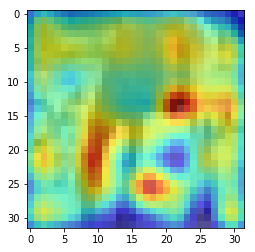

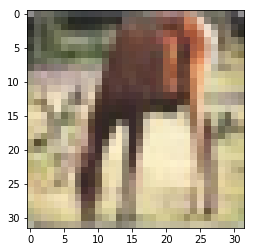

Predict : deer 	 Ans : deer


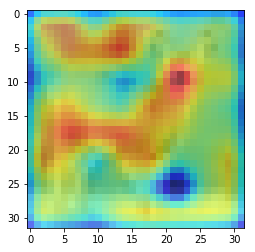

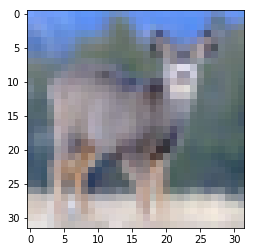

Predict : plane 	 Ans : plane


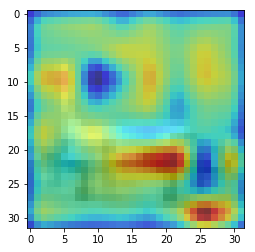

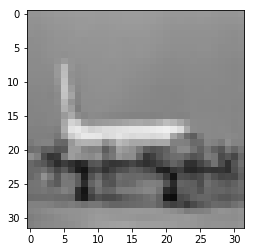

Predict : deer 	 Ans : horse


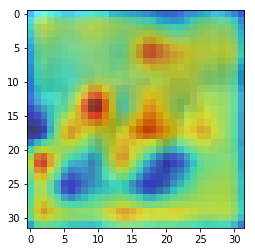

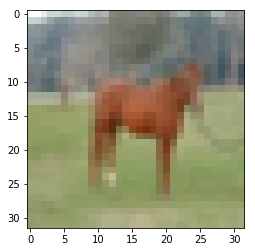

Predict : ship 	 Ans : ship


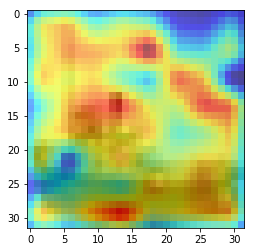

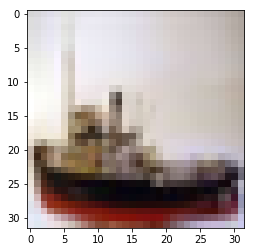

Predict : bird 	 Ans : bird


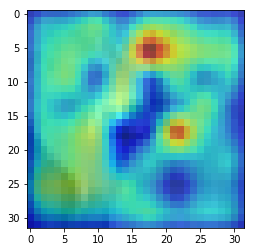

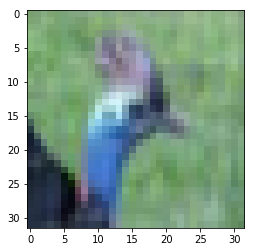

Predict : car 	 Ans : car


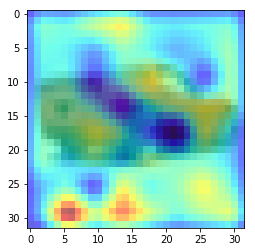

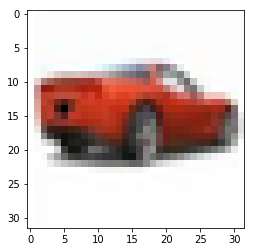

Predict : bird 	 Ans : bird


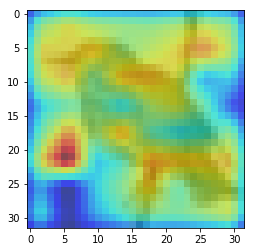

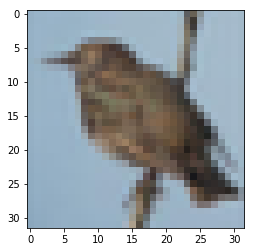

Predict : dog 	 Ans : dog


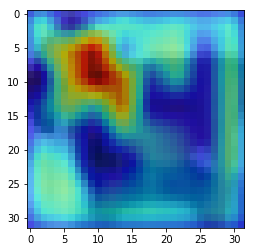

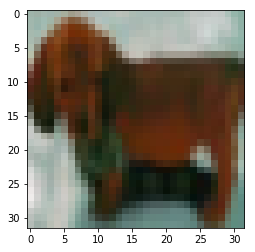

Predict : bird 	 Ans : deer


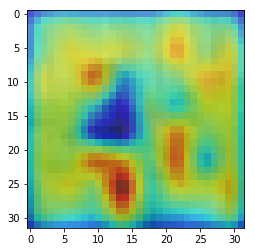

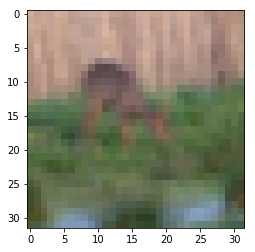

Predict : frog 	 Ans : frog


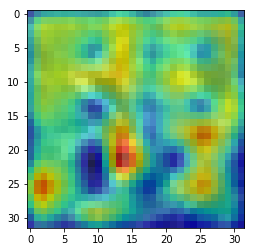

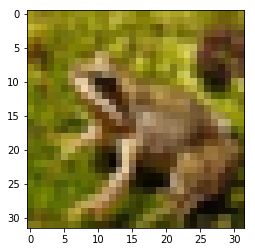

Predict : plane 	 Ans : plane


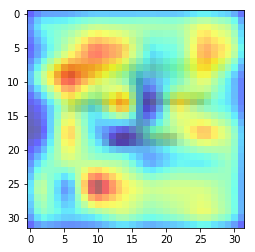

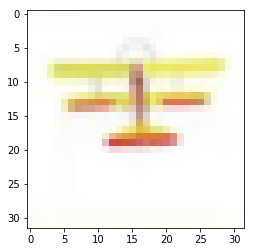

Predict : dog 	 Ans : dog


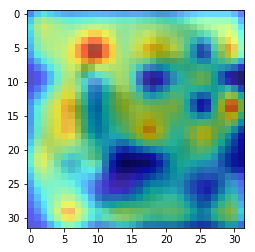

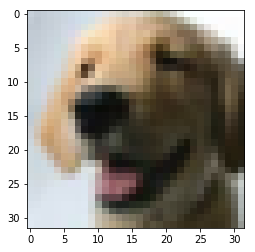

Predict : plane 	 Ans : horse


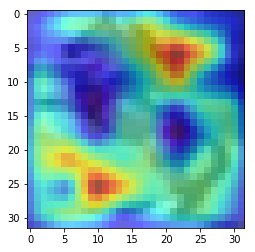

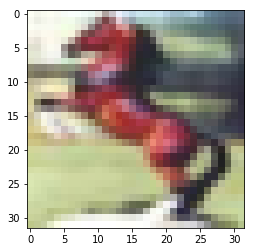

Predict : ship 	 Ans : deer


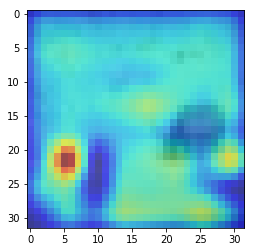

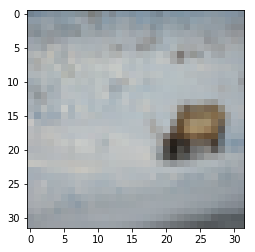

Predict : deer 	 Ans : deer


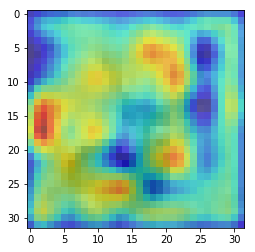

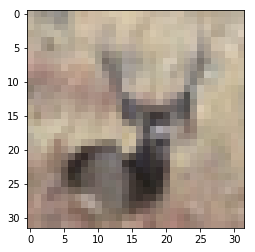

Predict : deer 	 Ans : cat


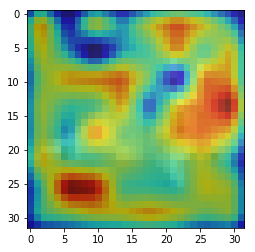

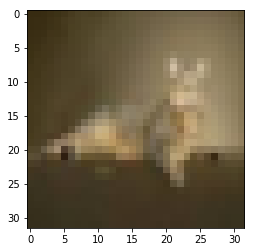

Predict : truck 	 Ans : truck


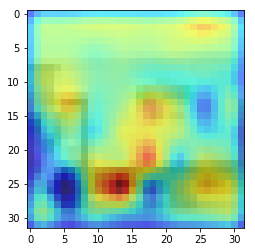

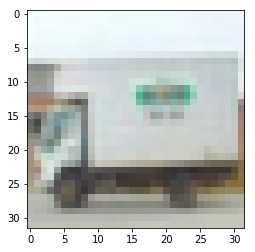

Predict : bird 	 Ans : dog


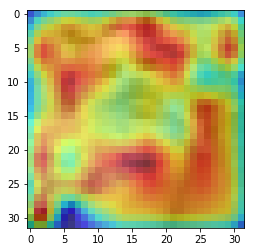

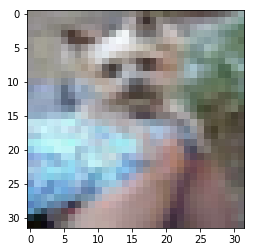

Predict : ship 	 Ans : ship


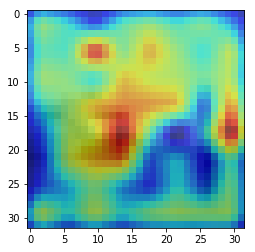

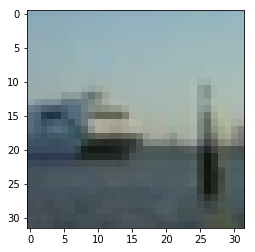

Predict : truck 	 Ans : ship


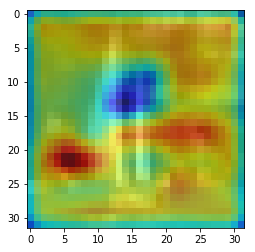

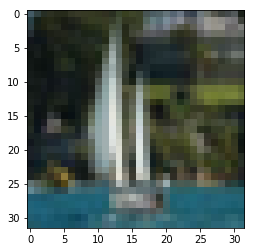

Predict : plane 	 Ans : plane


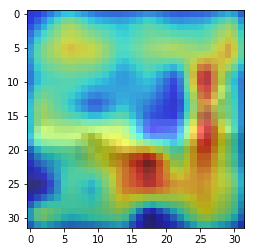

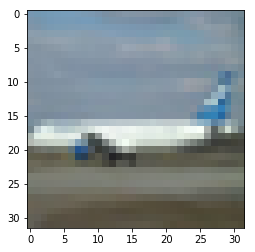

Predict : ship 	 Ans : ship


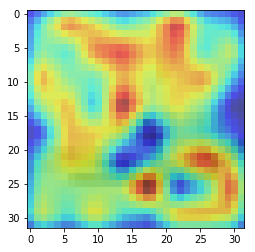

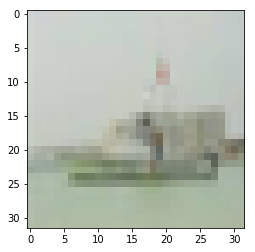

Predict : bird 	 Ans : horse


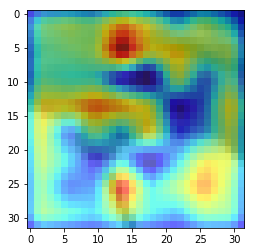

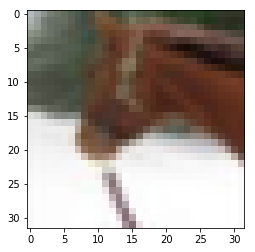

Predict : deer 	 Ans : deer


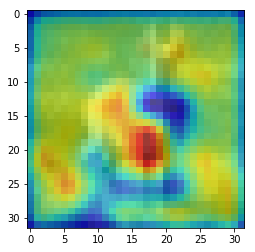

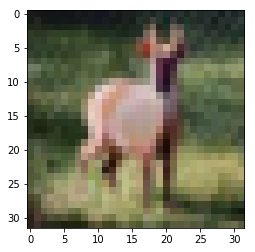

Predict : car 	 Ans : car


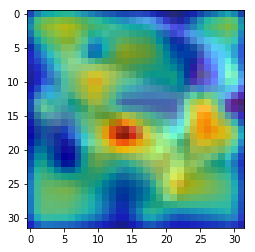

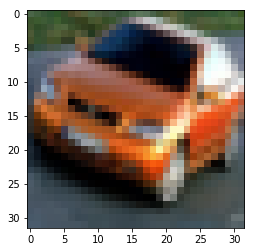

Predict : ship 	 Ans : ship


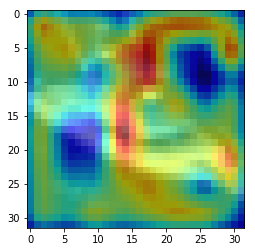

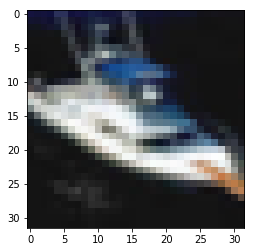

Predict : deer 	 Ans : deer


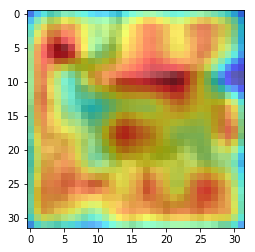

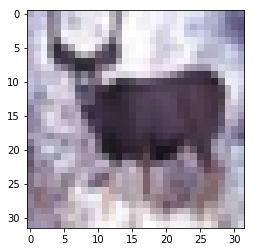

Predict : truck 	 Ans : truck


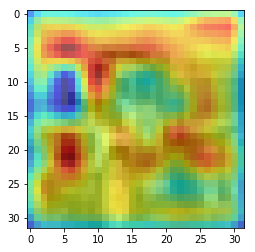

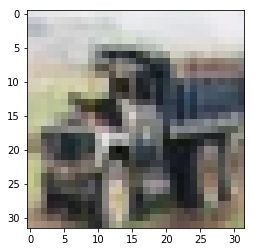

Predict : dog 	 Ans : dog


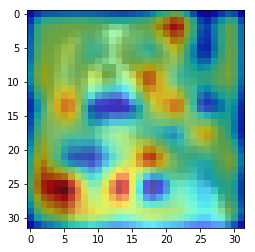

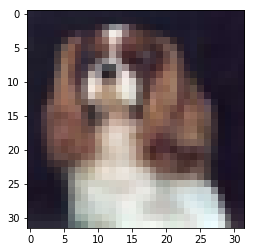

Predict : deer 	 Ans : deer


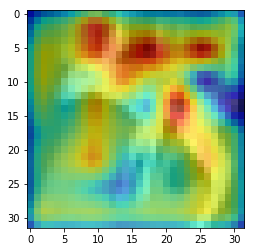

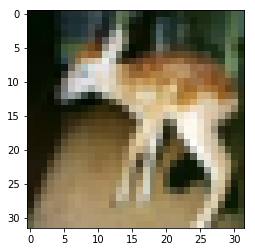

Predict : car 	 Ans : car


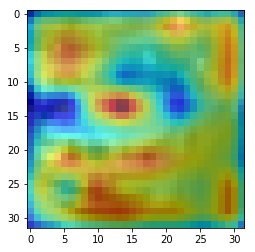

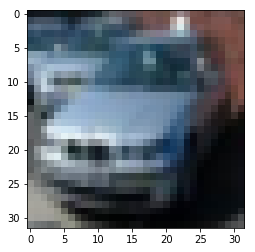

Predict : horse 	 Ans : horse


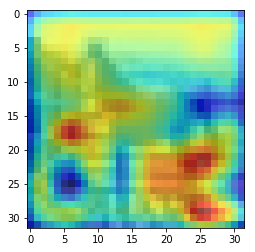

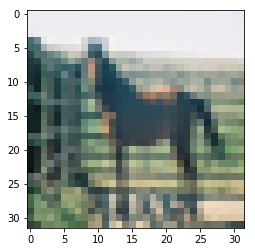

Predict : horse 	 Ans : horse


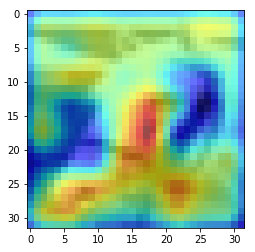

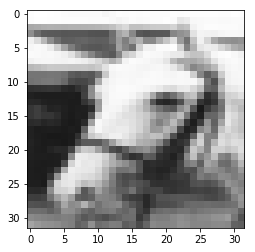

Predict : horse 	 Ans : horse


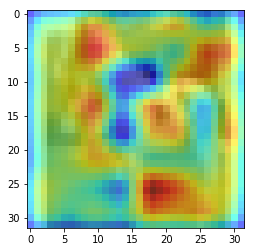

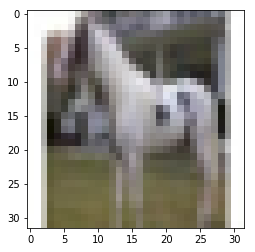

Predict : horse 	 Ans : horse


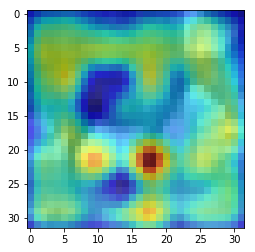

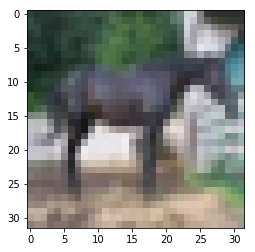

Predict : plane 	 Ans : plane


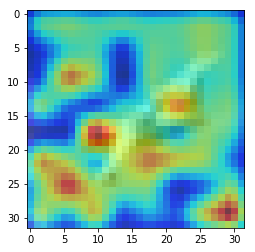

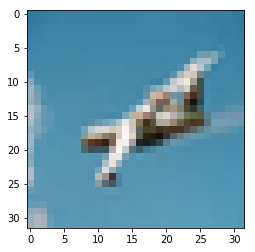

Predict : cat 	 Ans : cat


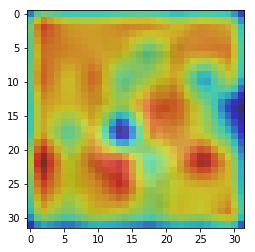

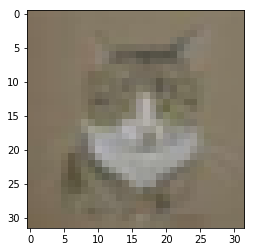

Predict : ship 	 Ans : ship


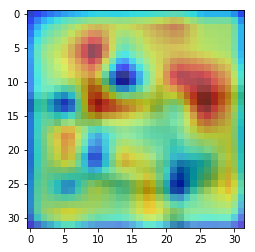

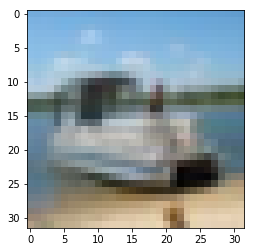

Predict : bird 	 Ans : cat


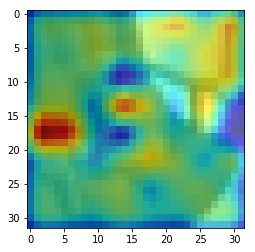

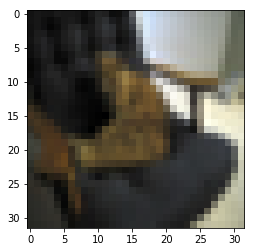

Predict : deer 	 Ans : cat


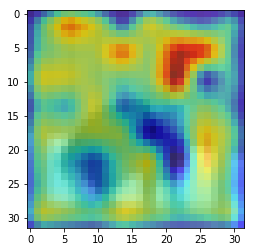

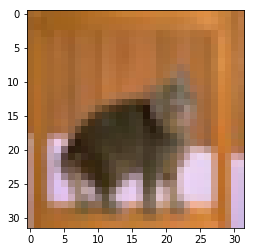

Predict : plane 	 Ans : plane


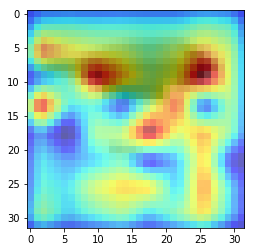

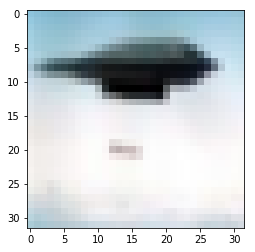

Predict : dog 	 Ans : dog


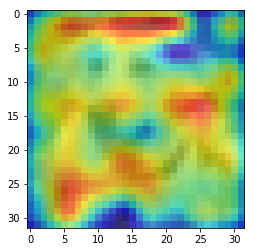

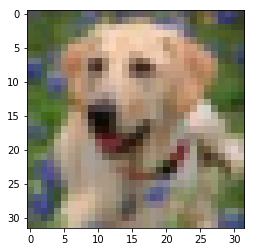

Predict : bird 	 Ans : horse


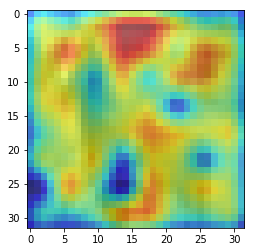

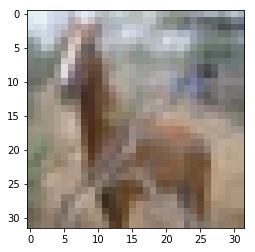

Predict : plane 	 Ans : plane


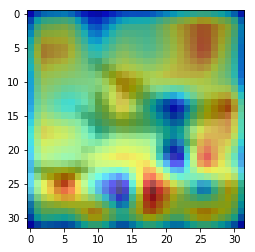

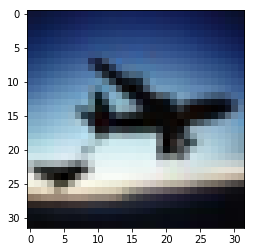

Predict : ship 	 Ans : ship


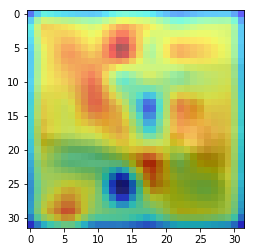

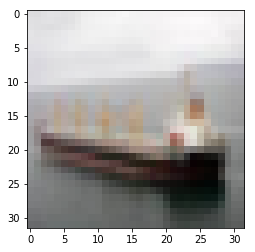

Predict : plane 	 Ans : plane


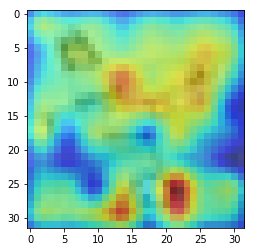

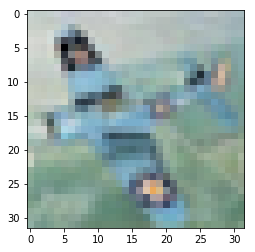

Predict : plane 	 Ans : plane


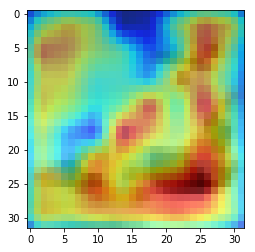

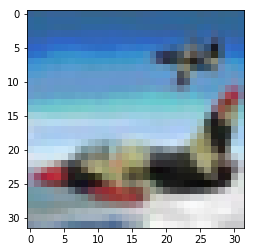

Predict : truck 	 Ans : truck


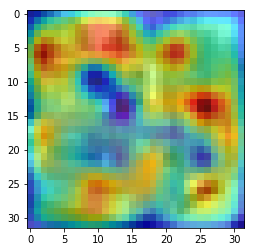

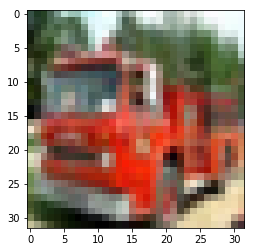

Predict : bird 	 Ans : bird


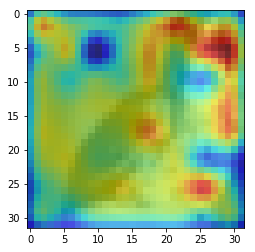

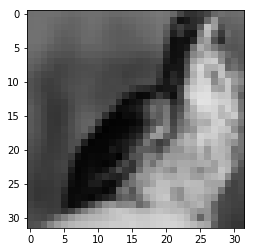

Predict : plane 	 Ans : bird


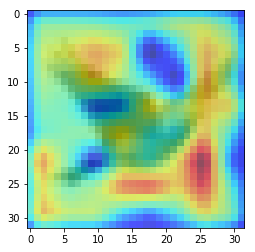

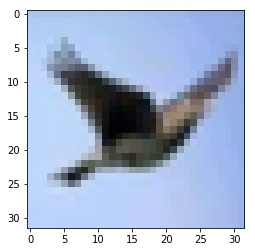

Predict : cat 	 Ans : cat


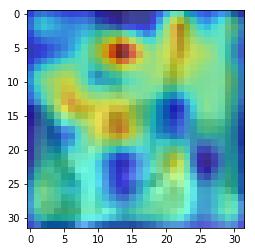

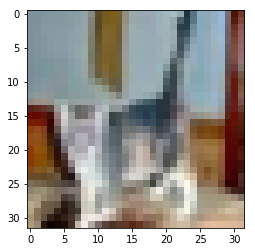

Predict : deer 	 Ans : deer


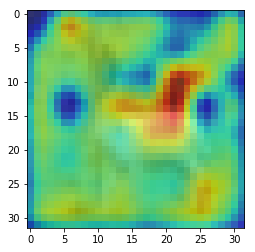

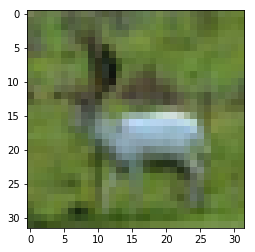

Predict : ship 	 Ans : ship


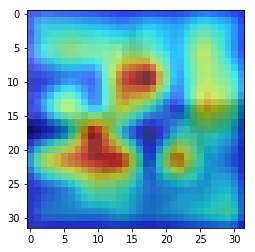

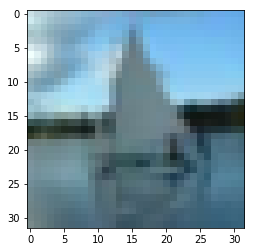

In [23]:
import skimage.transform

params = list(model.parameters())
num = 0

for num in range(64):
    print("Predict :",classes[int(predicted[num])],"\t Ans :",classes[int(labels[num])])
    
    overlay = params[-2][int(predicted[num])].matmul(f[num].reshape(128,64)).reshape(8, 8).cpu().data.numpy()

    overlay = overlay - np.min(overlay)
    overlay = overlay / np.max(overlay)
    
    imshow(images[num].cpu())
    skimage.transform.resize(overlay, [32,32])
    plt.imshow(skimage.transform.resize(overlay, [32, 32]), alpha=0.6,cmap='jet')
    plt.show()
    imshow(images[num].cpu())
    plt.show()

In [19]:
f.shape

torch.Size([100, 128, 8, 8])